In [45]:
#import libraries
import os
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from plotly.graph_objs import *
import plotly.figure_factory as ff
import pickle 
import quandl
import matplotlib.pyplot as plt
import cufflinks as cf
from IPython.display import Image

In [23]:
#initialize plotly
py.init_notebook_mode(connected=True)

In [24]:
#connect to quandl 
quandl.ApiConfig.api_key = "CpWibLx_pVZzRsJP2xxe"

In [25]:
#function to merge columns by name to new dataframe
def merge_dfs_on_column(dataframes, labels, col):
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
    return pd.DataFrame(series_dict)

In [26]:
#Retrieve BTC USD price
btc_kraken_df = quandl.get("BCHARTS/KRAKENUSD", start_date = "2015-01-02")

In [27]:
#get price data for additional exchanges
exchanges= ['COINBASE', 'BITSTAMP', 'ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_kraken_df

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = quandl.get(exchange_code)
    exchange_data[exchange] = btc_exchange_df
    


In [28]:
#Aggreate average of columns to fill holes in data
btc_open = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Open')
btc_high = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'High')
btc_close = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Close')
btc_low = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Low')
btc_volume = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Volume (Currency)')
#create BTC dataframe                               
btc_data = pd.DataFrame()
btc_data['open'] = btc_open.mean(axis=1)
btc_data['high']=  btc_high.mean(axis=1)
btc_data['close'] = btc_close.mean(axis=1)
btc_data['low'] = btc_low.mean(axis=1)
btc_data['volume'] = btc_volume.mean(axis=1)
btc_data = btc_data.iloc[btc_data.index >= '2015-01-01']


In [29]:
#connect to poloniex public api
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)


In [30]:
#Poloniex Api call
def get_crypto_data(poloniex_pair):
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = pd.read_json(json_url)
    #df = df.drop(['open', 'quoteVolume', 'weightedAverage'], axis=1)
    df = df.set_index('date')
    return df

In [31]:
#list of assets to analyze

assets = ['BTC','ETH','LTC','XRP','STR','XMR', 'SP500']
#create dict of dataframes of each asset
asset_data = {}
for asset in assets:
    if asset == 'SP500':
        path = '{}.csv'.format(asset)
        df = read_csv(path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        asset_data[asset] = df 
    elif asset == 'BTC':
        asset_data[asset] = btc_data
    else:
        coinpair = 'BTC_{}'.format(asset)
        df = get_crypto_data(coinpair)
        temp_two_df = btc_data
        temp_two_df = temp_two_df.reindex(index = df.index, method ='ffill')
        #convert btc-asset pair to USD
        df = df.mul(temp_two_df['close'].fillna(1), axis =0)
        asset_data[asset] = df

In [32]:
#plotly function to plot all close prices
def price_subplots(df):
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    fig = tools.make_subplots(rows=3, cols=3)
    # Form Trace For Each Series
    trace_arr = []
    row=1 
    col=1
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=True
        )
        if col < 4 :
            fig.append_trace(trace,row,col)
            col += 1
        else:
            row += 1
            col -= 3
            fig.append_trace(trace,row,col)
            col += 1
    fig['layout'].update(height=600, width=900, title = ('Cryptocurrency Historical Prices'))
    
    py.iplot(fig)


In [33]:
#merge on asset close prices to one datafrane
close_price_df = merge_dfs_on_column(list(asset_data.values()), list(asset_data.keys()), 'close')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



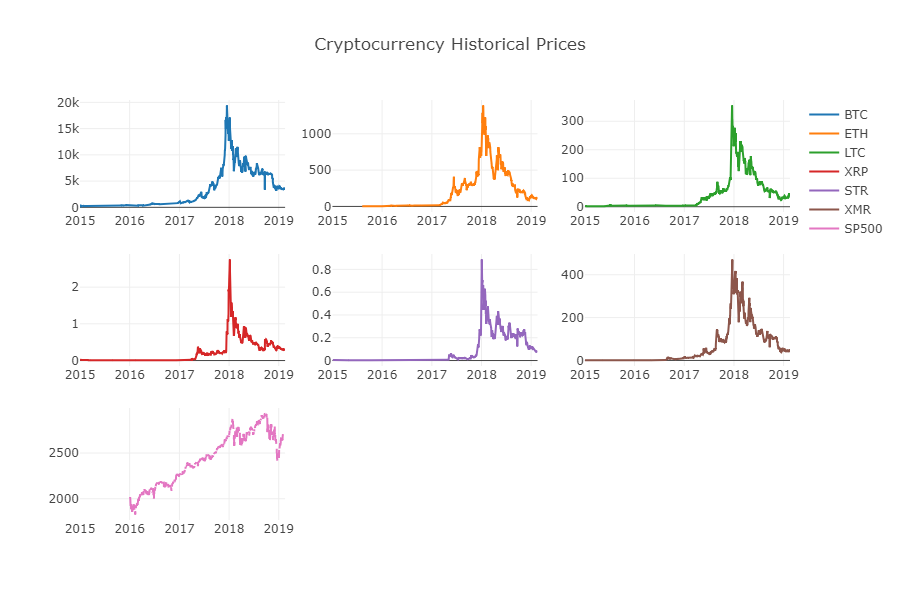

In [49]:
price_subplots(close_price_df)
Image("Crypto_Close_Subplot.png")

In [51]:
#plotly function to create candlestick charts
def candlestick(asset):
    increasing_color = '#1f8e1d'
    decreasing_color = '#e52222'
    
    data = [ dict(
        type = 'candlestick',
        open = asset_data[asset].open,
        high = asset_data[asset].high,
        low = asset_data[asset].low,
        close = asset_data[asset].close,
        x = asset_data[asset].index,
        name = str(asset),
        increasing = dict( line = dict( color = increasing_color) ),
        decreasing = dict( line = dict( color = decreasing_color ) )
    )]
    
    layout = dict()

    fig = dict(data = data, layout=layout)
    
    fig['layout'] = dict()
    fig['layout']['plot_bgcolor'] = '#ffffff'
    fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
    fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )
    
    def movingaverage(interval, window_size=10):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'same')
    
    mv_y = movingaverage(asset_data[asset].close)
    mv_x = list(asset_data[asset].index)

    # Clip the ends
    mv_x = mv_x[5:-5]
    mv_y = mv_y[5:-5]

    fig['data'].append( dict( x=mv_x, y=mv_y, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#000000' ),
                         name='Moving Average' ) )
    
    
    def bbands(price, window_size=10, num_of_std=3):
        rolling_mean = price.rolling(window=window_size).mean()
        rolling_std  = price.rolling(window=window_size).std()
        upper_band = rolling_mean + (rolling_std*num_of_std)
        lower_band = rolling_mean - (rolling_std*num_of_std)
        return rolling_mean, upper_band, lower_band
 
    bb_avg, bb_upper, bb_lower = bbands(asset_data[asset].close)
    
    fig['data'].append( dict(x = asset_data[asset].index, y=bb_upper, type='scatter',  
                         line = dict( width = 1 ),
                         marker=dict(color='#1f8e1d'), hoverinfo='none', 
                         legendgroup='Bollinger Bands', name='Bollinger Bands') )

    
    fig['data'].append( dict(x = asset_data[asset].index, y=bb_lower, type='scatter', 
                         line = dict( width = 1 ),
                         marker=dict(color='#e52222'), hoverinfo='none',
                         legendgroup='Bollinger Bands', showlegend=False ) )


    
    py.iplot( fig, filename = 'candlestick', validate = False )
    

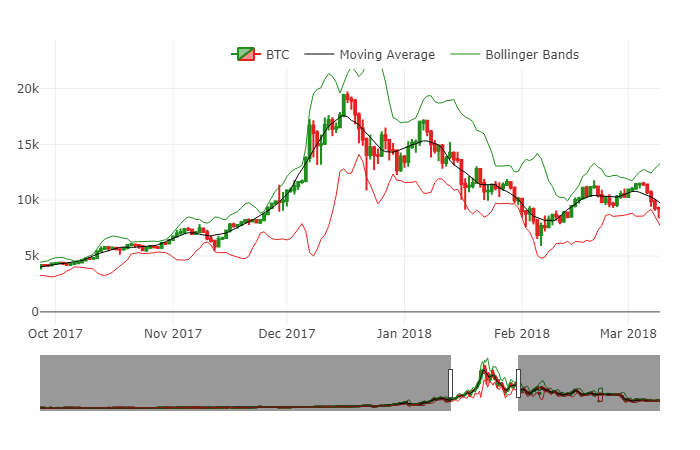

In [52]:
candlestick('BTC')
Image("Candlestick_BTC.png")

In [38]:
#plotly charting function
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=True
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

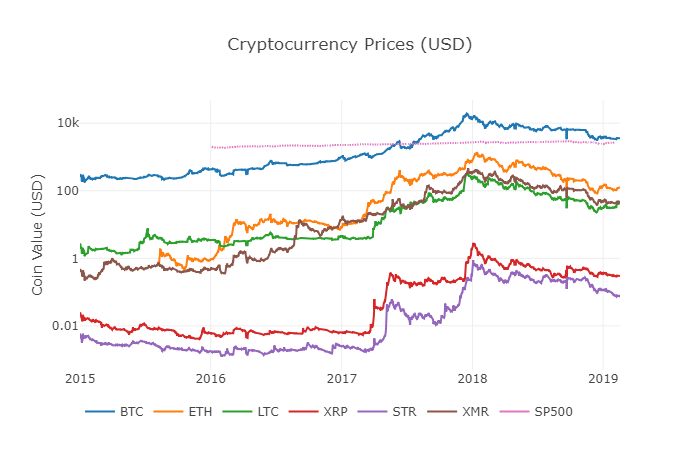

In [54]:
# Chart all of the assets
df_scatter(close_price_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')
Image("Crypto_Log_Prices.png")

In [40]:
#function to graph heatmap of correlations between different assets
def correlation_heatmap(df, title, absolute_bounds=True):
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [41]:
close_price_df.pct_change().corr(method='pearson')

,BTC,ETH,LTC,XRP,STR,XMR,SP500
BTC,1.000000,0.594165,0.705596,0.463169,0.496626,0.627526,0.034617
ETH,0.594165,1.000000,0.537436,0.365976,0.385564,0.505897,0.042706
LTC,0.705596,0.537436,1.000000,0.443138,0.451534,0.516078,0.048308
XRP,0.463169,0.365976,0.443138,1.000000,0.585838,0.367873,0.046738
STR,0.496626,0.385564,0.451534,0.585838,1.000000,0.435236,0.044844
XMR,0.627526,0.505897,0.516078,0.367873,0.435236,1.000000,0.044210
SP500,0.034617,0.042706,0.048308,0.046738,0.044844,0.044210,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



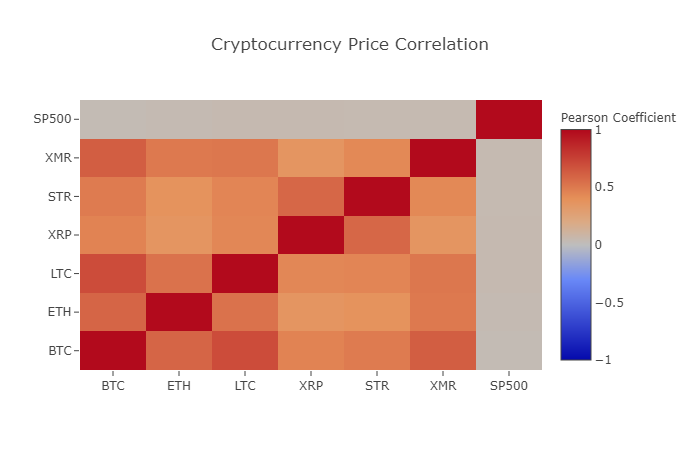

In [55]:
correlation_heatmap(close_price_df.pct_change(), "Cryptocurrency Price Correlation")
Image("Heatmap_Correlation.png")